In [24]:
import torch 
from torch import nn

import matplotlib.pyplot as plt

print(torch.__version__)

2.2.0


# Linear Regression Model 

Another example of a non-neural network model.

In [25]:
# "simple straight line"
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()

        #init model parameters to something random - only one node
        self.weight = nn.Parameter(torch.rand(1,requires_grad=True,dtype=torch.float))
        self.bias = nn.Parameter(torch.rand(1,requires_grad=True,dtype=torch.float))
        
    #forward (computation) method
        #operation that the model does
    def forward(self, data:torch.Tensor) -> torch.Tensor:
        return self.weight * data + self.bias

In [26]:
#testing data

#for the sake of clarity - 
# we know what the ideal weight and bias is here
IDEAL_WEIGHT = 0.7
IDEAL_BIAS = 0.3

#all the data
#we want the model to : get x - return y
tensor32_x = torch.arange(0,1,0.02).unsqueeze(dim=1) #unsqueeze ; each value array of their own

tensor32_y = IDEAL_WEIGHT * tensor32_x + IDEAL_BIAS #lin reg formula

#splitting testing data 80 train - 20 test
point_to_split = int(0.8 * len(tensor32_x)) #80 % of data -> training set/split

train_set_X = tensor32_x[:point_to_split] #everything before the split
train_set_y = tensor32_y[:point_to_split]

test_set_X = tensor32_x[point_to_split:] #everything after the split (onwards)
test_set_y = tensor32_y[point_to_split:]


In [27]:
#plot function
def plot_predictions(
                    train_data,
                    train_labels,
                    test_data,
                    test_labels,
                    predictions=None):
    
    plt.figure(figsize=(10,7))

    if train_data is not None:
        #training data - blue
        plt.scatter(train_data, train_labels, c='b', s=4, label="training data")

    if test_data is not None:
        #test data - green ; what we are looking at
        plt.scatter(test_data, test_labels, c='g', s=4, label="testing data")


    #are there predictions 
    if predictions is not None:
        #predictions - red; what we got from the model ; ideal green = red
        plt.scatter(test_data, predictions, c='r', s=4, label="predictions")

    #legend
    plt.legend(prop={"size":14})

    plt.show() #opens a seperate window ..

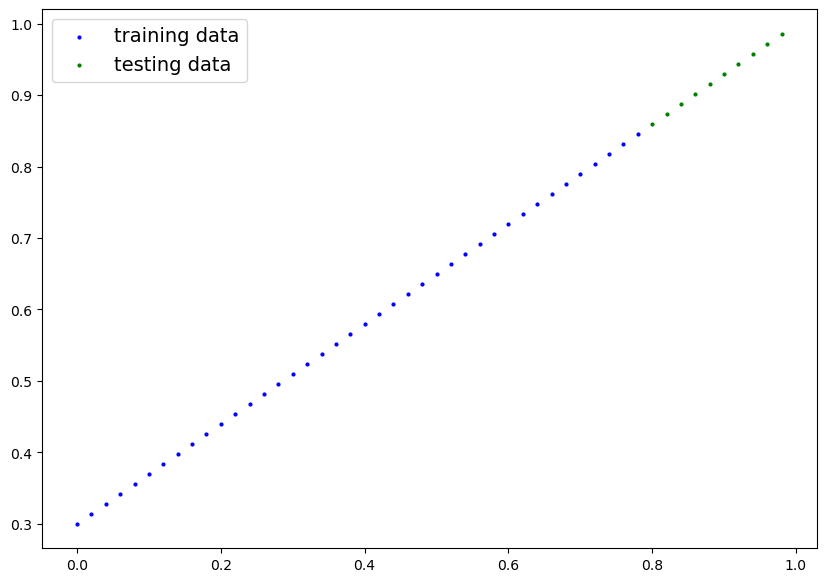

In [28]:
#show the split - of testing and training data
plot_predictions(train_set_X, train_set_y, test_set_X, test_set_y)

In [29]:
#create instance of a model
linreg_model = LinearRegressionModel()

Let's see how our model preforms.

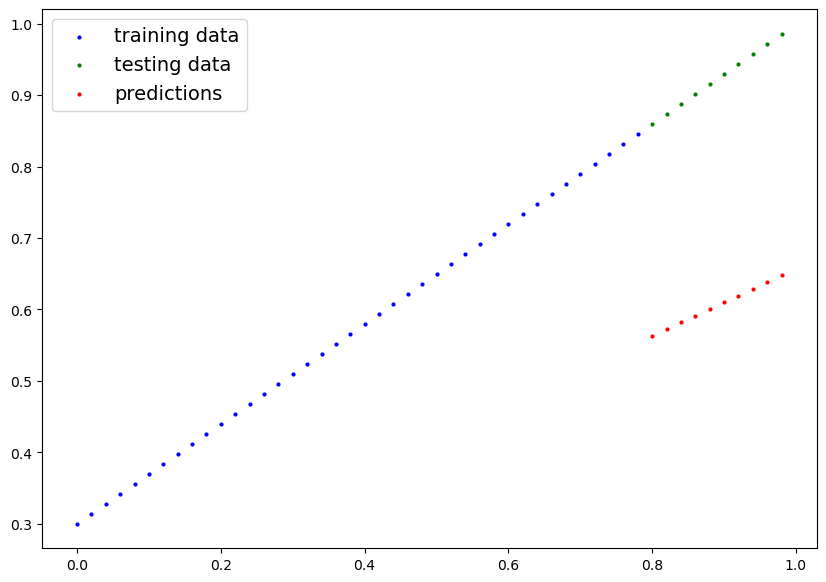

In [30]:
#testing the model before any training
with torch.inference_mode(): #context managerr ; inference = prediction mode ; not saved to memory
    predictions_y = linreg_model(test_set_X)

plot_predictions(train_set_X, train_set_y, test_set_X, test_set_y, predictions=predictions_y)

.. It would appear an untrained model doesn't know what it is doing ! who would have though. But on a real note - this showcases what random initilazation does. 

The problem is that our model has no idea it is doing a bad job at predicting the linear values. This is where the loss function comes into play.

In linear regression models we generally use either MSE/L1.

In [31]:
loss_function = nn.L1Loss()

This is also when we pick our optimization algorithm. Let's pick a simple one, mean squared error or log loss.

In [33]:
optimization_algorithm = nn.L1Loss()